## Michael Beven - 455613
## University of Chicago - Financial Mathematics
## FINM 33150 - Quantitative Strategies and Regression
## Homework 4

### Tables and column descriptions

* **Swap data (```USDswap | GBPswap | EURswap```)**:
 * Index: DATE (daily)
 * ```1``` ~ 1 year swap rate
 * ```2``` ~ 2 year swap rate
 * ```5``` ~ 5 year swap rate
 
 
* **LIBOR data (```LIBOR```)**:
 * Index: Date (weekly)
 * ```USD3M``` ~ 3 month USD LIBOR rate
 * ```GBP3M``` ~ 3 month GBP LIBOR rate
 * ```EUR3M``` ~ 3 month EUR LIBOR rate
 * ```AUD3M``` ~ 3 month AUD LIBOR rate
 * ```USDAccrued``` ~ Amount accrued over a week at USD LIBOR + 50bps
 * ```GBPAccrued``` ~ Amount accrued over a week at GBP LIBOR + 50bps
 * ```EURAccrued``` ~ Amount accrued over a week at EUR LIBOR + 50bps
 * ```AUDAccrued``` ~ Amount accrued over a week at AUD LIBOR + 50bps
 * ```USDAccrued_lend``` ~ Amount accrued over a week at USD LIBOR
 * ```GBPAccrued_lend``` ~ Amount accrued over a week at GBP LIBOR
 * ```EURAccrued_lend``` ~ Amount accrued over a week at EUR LIBOR
 * ```AUDAccrued_lend``` ~ Amount accrued over a week at AUD LIBOR


* **Boostrapped swap data (```USDswap_zcb | GBPswap_zcb | EURswap_zcb```)**:
 * Index: Date (weekly)
 * ```1``` ~ 1 year zero rate
 * ```2``` ~ 2 year zerp rate
 * ```5``` ~ 5 year zerp rate
 * ```BondLend``` ~ Bond price with 5 year tenor and coupon = 5 year swap rate
 * ```BondReturn``` ~ Bond price a week later with 5-1/52 years tenor and coupon = 5 year swap rate
 * ```MTM``` ~ Difference in BondReturn (adjusted by the FX rate) and BondLend (adjusted by the FX rate)


* **Combinations of fixed-float swap currencies being annalyzed (```FF```)**:
 * ```Fixed``` ~ Fixed currency
 * ```Floating``` ~ Floating currency


* **Final dataframe of results for the fixed-float swap (```df```)**:
 * Index: Date (weekly)
 * ```Fixed_CF``` ~ Fixed cashflow
 * ```Floating_CF``` ~ Floating cashflow
 * ```Signal``` ~ Cancel trade if 5 year swap rates of fixed and floating are within 50bps of each other
 * ```Net_CF``` ~ ```Fixed_CF``` - ```Floating_CF```
 * ```Ret``` ~ ```Net_CF```/2000000
 * ```NegRet``` ~ Negative returns (used for calculating the Sortino ratio)
 * ```CumRet``` ~ Cumulative returns (cumulative net cashflows divided by capital)
 * ```1YrRollingCumRet``` ~ 1 year rolling cumulative returns
 * ```1YrRollingSharpe``` ~ 1 year rolling Sharpe ratio
 * ```1YrRollingSortino``` ~ 1 year rolling Sortino ratio


* **Combinations of basis swap currencies being annalyzed (```B```)**:
 * ```Fund``` ~ Lending currency
 * ```Borrow``` ~ Borrowing currency


* **Final dataframe of results for the basis swap (```df```)**:
 * Index: Date (weekly)
 * ```Fund_CF``` ~ Lending cashflow
 * ```Borrow_CF``` ~ Borrowing cashflow
 * ```Signal``` ~ Cancel trade if 5 year swap rates of fixed and floating are within 50bps of each other
 * ```Net_CF``` ~ ```Fixed_CF``` - ```Floating_CF```
 * ```Ret``` ~ ```Net_CF```/2000000
 * ```NegRet``` ~ Negative returns (used for calculating the Sortino ratio)
 * ```CumRet``` ~ Cumulative returns (cumulative net cashflows divided by capital)
 * ```1YrRollingCumRet``` ~ 1 year rolling cumulative returns
 * ```1YrRollingSharpe``` ~ 1 year rolling Sharpe ratio
 * ```1YrRollingSortino``` ~ 1 year rolling Sortino ratio
 
 
 
### Code and Analysis


** First we retrieve all necessary packages and set up the ipython notebook:**

In [13]:
#~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*#
# Michael Beven                                        #
# University of Chicago - Financial Mathematics        #
# FINM 33150 - Quantitative Strategies and Regression  #
# Homework 4                                           #
#~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*#

##########################
# ipython notebook setup #
##########################

import pandas as pd
import numpy as np
import Quandl
import keyring as kr # hidden password
key = kr.get_password('Quandl','mbeven')
import sqlite3 as sql
import time
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
db = '/Users/michaelbeven/Documents/06_School/2016 Spring/FINM_2016_SPRING/FINM 33150/HW4/Interbank_Rates.db'
warnings.filterwarnings('ignore')
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 82)
pd.set_option('precision', 3)

**Next we set the global parameters.  ```notional``` is the USD10million have in total for the strategy, ```K``` is the actual capital (USD2million) and ```leverage``` is the difference.  The end date is set as today's date**:

In [14]:
##############
# parameters #
##############

notional = 10**7 # lending amount
K = 2*10**6 # capital
leverage= notional - K # borrowing amount
start_date = '2002-01-01'
end_date = time.strftime("%x") #today

**We will also need to boostrap the swaps data obtained for the strategy, then calculate their theoretical bond prices.  Hence, the two functions below will be used:**

In [15]:
##################
# rate functions #
##################

def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.index:
        spot = spot_rates_curve[spot_rates_curve.index==curve]
        for tenor, spot_rate in spot.iteritems():
            if float(tenor)>0.001:
                times = np.arange(float(tenor)-0.25, 0, step=-0.25)[::-1]
                coupon_quarter_yr = float(0.25*spot_rate)
                z = np.interp(times, zcb_rates[spot_rates_curve.index==curve].columns.values.astype(float), zcb_rates[spot_rates_curve.index==curve].values[0,:]) # Linear interpolation
                preceding_coupons_val = (coupon_quarter_yr*np.exp(-z*times)).sum()
                zcb_rates.loc[spot_rates_curve.index==curve,tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_quarter_yr))/float(tenor)
    return zcb_rates
    
def bond_price(zcb,c,T):
  bond_prices =  zcb.iloc[:,0]*0
  for curve in zcb.index:
    t = np.arange(T,0,step=-0.25)[::-1]
    r = np.interp(t,zcb[zcb.index==curve].columns.values.astype(float),zcb[zcb.index==curve].values[0,:]) # Linear interpolation
    p = np.exp(-T*r[-1]) + 0.25*c[curve]*np.exp(-r*t).sum()
    bond_prices[curve] = p
  return bond_prices

**The data has been sourced from different locations.  All LIBOR data, foreign exchange rates and USD swap rates are from Quandl, while GBP, EUR and AUD swap rates are from a database accessed through sqlite3.  Swap data is stored in dictionaries, which will be handy for looping through the strategy on different currency pairs.  Missing days of data have been backfilled (see the end of the cell below)**:

In [16]:
########
# data #
########

swap = {}
USDFX_codes = list(('CURRFX/USDGBP.1','CURRFX/USDEUR.1','CURRFX/USDAUD.1'))
USDFX = Quandl.get(USDFX_codes,authtoken=key,trim_start='2002-01-02',trim_end=end_date,returns="pandas",collapse='weekly').shift(1,freq='B')
USDFX.columns = ['USDGBP','USDEUR','USDAUD']
USDFX.USDAUD[USDFX.USDAUD<0.3]=1.28
LIBOR_codes = list(('FRED/USD3MTD156N','FRED/EUR3MTD156N','FRED/GBP3MTD156N','FRED/AUD3MTD156N'))
LIBOR = Quandl.get(LIBOR_codes,authtoken=key,trim_start=start_date,trim_end=end_date,returns="pandas").fillna(method='ffill')/100
LIBOR.columns = ['USD3M','EUR3M','GBP3M','AUD3M']
USDswap_codes = list(('FRED/DSWP1','FRED/DSWP2','FRED/DSWP5'))
USDswap = Quandl.get(USDswap_codes,authtoken=key,trim_start=start_date,trim_end=end_date,returns="pandas")/100
USDswap.columns = ['1','2','5']
cursor = sql.connect(db).cursor() # sql access
cursor.execute(("SELECT observation_date, rate FROM interbank_rates WHERE is_forward = 0 and tenor_years = '1.0' and currency = 'GBP' and observation_date >= '2002-01-01';"))
GBP1Yswap = pd.DataFrame(cursor.fetchall(),columns = ['date','1']).set_index('date').fillna(method='ffill')
GBP1Yswap = GBP1Yswap.set_index(pd.to_datetime(GBP1Yswap.index))
cursor.execute(("SELECT observation_date, rate FROM interbank_rates WHERE is_forward = 0 and tenor_years = '2.0' and currency = 'GBP' and observation_date >= '2002-01-01';"))
GBP2Yswap = pd.DataFrame(cursor.fetchall(),columns = ['date','2']).set_index('date').fillna(method='ffill')
GBP2Yswap = GBP2Yswap.set_index(pd.to_datetime(GBP2Yswap.index))
cursor.execute(("SELECT observation_date, rate FROM interbank_rates WHERE is_forward = 0 and tenor_years = '5.0' and currency = 'GBP' and observation_date >= '2002-01-01';"))
GBP5Yswap = pd.DataFrame(cursor.fetchall(),columns = ['date','5']).set_index('date').fillna(method='ffill')
GBP5Yswap = GBP5Yswap.set_index(pd.to_datetime(GBP5Yswap.index))
cursor.execute(("SELECT observation_date, rate FROM interbank_rates WHERE is_forward = 0 and tenor_years = '1.0' and currency = 'EUR' and observation_date >= '2002-01-01';"))
EUR1Yswap = pd.DataFrame(cursor.fetchall(),columns = ['date','1']).set_index('date').fillna(method='ffill')
EUR1Yswap = EUR1Yswap.set_index(pd.to_datetime(EUR1Yswap.index))
cursor.execute(("SELECT observation_date, rate FROM interbank_rates WHERE is_forward = 0 and tenor_years = '2.0' and currency = 'EUR' and observation_date >= '2002-01-01';"))
EUR2Yswap = pd.DataFrame(cursor.fetchall(),columns = ['date','2']).set_index('date').fillna(method='ffill')
EUR2Yswap = EUR2Yswap.set_index(pd.to_datetime(EUR2Yswap.index))
cursor.execute(("SELECT observation_date, rate FROM interbank_rates WHERE is_forward = 0 and tenor_years = '5.0' and currency = 'EUR' and observation_date >= '2002-01-01';"))
EUR5Yswap = pd.DataFrame(cursor.fetchall(),columns = ['date','5']).set_index('date').fillna(method='ffill')
EUR5Yswap = EUR5Yswap.set_index(pd.to_datetime(EUR5Yswap.index))
GBPswap = pd.concat((GBP1Yswap,GBP2Yswap,GBP5Yswap),axis=1)
EURswap = pd.concat((EUR1Yswap,EUR2Yswap,EUR5Yswap),axis=1)
swap['USD'] = USDswap.reindex(USDFX.index).fillna(method='bfill')
swap['GBP'] = GBPswap.reindex(USDFX.index).fillna(method='bfill')
swap['EUR'] = EURswap.reindex(USDFX.index).fillna(method='bfill')

**We now bootstrap the swaps data to price it.  A difference is taken between the bootstrapped price now versus the bootstrapped price 1 week from now, where both prices are adjusted by the necessary foreign exchange rate.  This will then incorporate foreign exchange movements into the pricing.  It is assumed that the next available day of rates is used when none are available on the desired day (e.g. on a holiday):**

In [17]:
####################
# lending currency #
####################

swap_zcb = {}
USDswap_zcb = compute_zcb_curve(USDswap).reindex(USDFX.index)
USDswap_zcb['BondLend'] = bond_price(USDswap_zcb,USDswap.reindex(USDFX.index)['5'],5)
USDswap_zcb['BondReturn'] = bond_price(USDswap_zcb.iloc[:,0:3],USDswap.reindex(USDFX.index)['5'],5-1/52)
USDswap_zcb['MTM'] = notional*(USDswap_zcb.BondReturn - USDswap_zcb.BondLend.shift(1))
swap_zcb['USD'] = USDswap_zcb.fillna(method='bfill')
GBPswap_zcb = compute_zcb_curve(GBPswap).reindex(USDFX.index)
GBPswap_zcb['BondLend'] = bond_price(GBPswap_zcb,GBPswap.reindex(USDFX.index)['5'],5)
GBPswap_zcb['BondReturn'] = bond_price(GBPswap_zcb.iloc[:,0:3],GBPswap.reindex(USDFX.index)['5'],5-1/52)
GBPswap_zcb['MTM'] = notional*(GBPswap_zcb.BondReturn*USDFX.USDGBP - GBPswap_zcb.BondLend.shift(1)*USDFX.shift(1).USDGBP)
swap_zcb['GBP'] = GBPswap_zcb.fillna(method='bfill')
EURswap_zcb = compute_zcb_curve(EURswap).reindex(USDFX.index)
EURswap_zcb['BondLend'] = bond_price(EURswap_zcb,EURswap.reindex(USDFX.index)['5'],5)
EURswap_zcb['BondReturn'] = bond_price(EURswap_zcb.iloc[:,0:3],EURswap.reindex(USDFX.index)['5'],5-1/52)
EURswap_zcb['MTM'] = notional*(EURswap_zcb.BondReturn*USDFX.USDEUR - EURswap_zcb.BondLend.shift(1)*USDFX.shift(1).USDEUR)
swap_zcb['EUR'] = EURswap_zcb.fillna(method='bfill')

**For the floating (borrowing) side of the fixed-float swap, we calculate weekly accrued interest using LIBOR+50bps.  This also takes the adjustment of the change in exchange rate over the week:**

In [18]:
######################
# borrowing currency #
######################

LIBOR['USDAccrued'] = leverage*1/52*(LIBOR.shift(1).USD3M+50/10000)
LIBOR['GBPAccrued'] = leverage*1/52*(LIBOR.shift(1).GBP3M+50/10000)*USDFX.USDGBP/USDFX.shift(1).USDGBP
LIBOR['EURAccrued'] = leverage*1/52*(LIBOR.shift(1).EUR3M+50/10000)*USDFX.USDEUR/USDFX.shift(1).USDEUR
LIBOR['AUDAccrued'] = leverage*1/52*(LIBOR.shift(1).AUD3M+50/10000)*USDFX.USDAUD/USDFX.shift(1).USDAUD

**The basis swap strategy requires lending at LIBOR.  Again, we make an adjustment for the change in exchange rate over the week:**

In [19]:
####################
# lending currency #
####################

LIBOR['USDAccrued_lend'] = notional*1/52*(LIBOR.shift(1).USD3M)
LIBOR['GBPAccrued_lend'] = notional*1/52*(LIBOR.shift(1).GBP3M)*USDFX.shift(1).USDGBP/USDFX.USDGBP
LIBOR['EURAccrued_lend'] = notional*1/52*(LIBOR.shift(1).EUR3M)*USDFX.shift(1).USDEUR/USDFX.USDEUR
LIBOR['AUDAccrued_lend'] = notional*1/52*(LIBOR.shift(1).AUD3M)*USDFX.shift(1).USDAUD/USDFX.USDAUD
LIBOR = LIBOR.reindex(USDFX.index).fillna(method='bfill')

**Finally, we create the results for the fixed-float strategy and plot them.  I am looping through all the desired combinations using a list of currencies in a dataframe called ```FF```.  Since we do not have swap rates for Australia, I have decided to run this strategy without the constraint that the 5 year swaps must be within 50bps of each other.  This section of code is heavily commented to show my steps:**

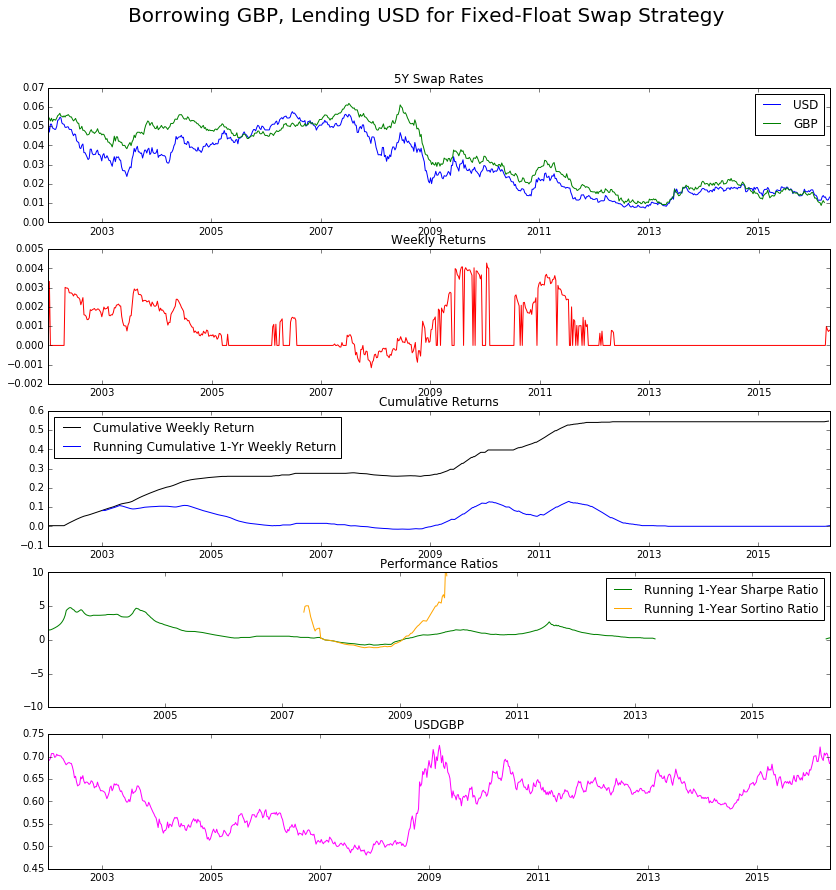

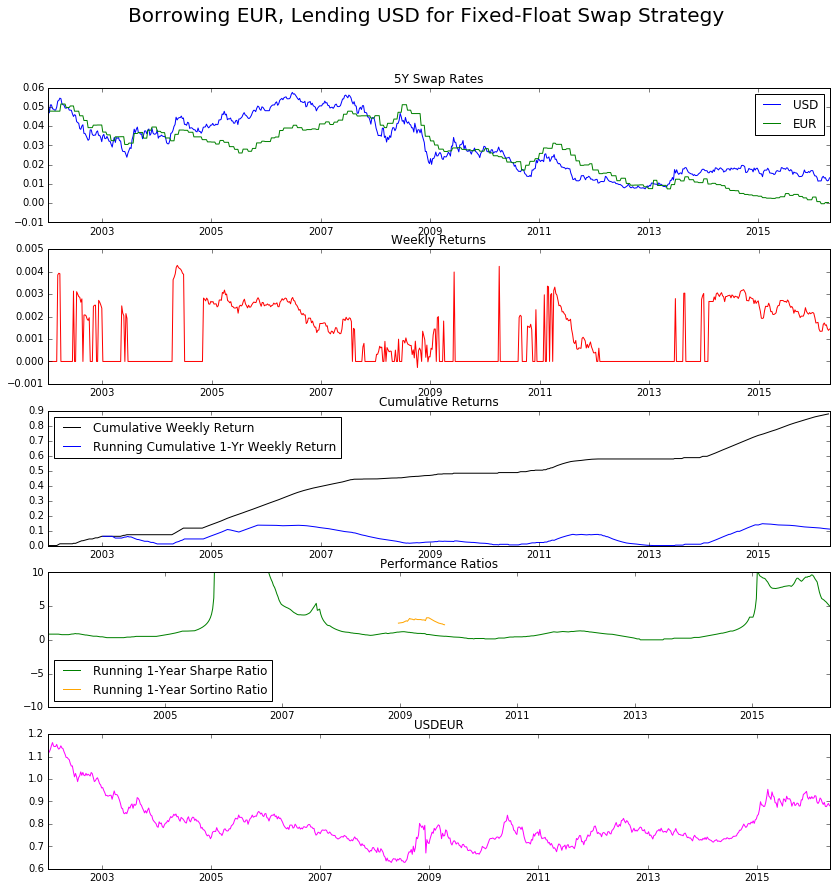

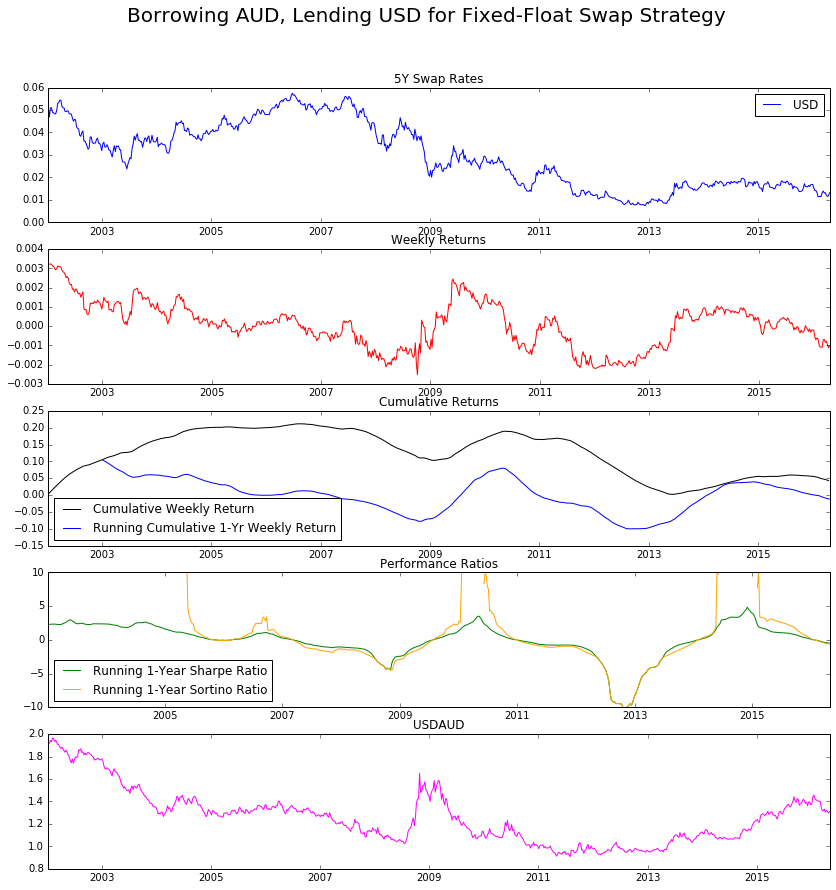

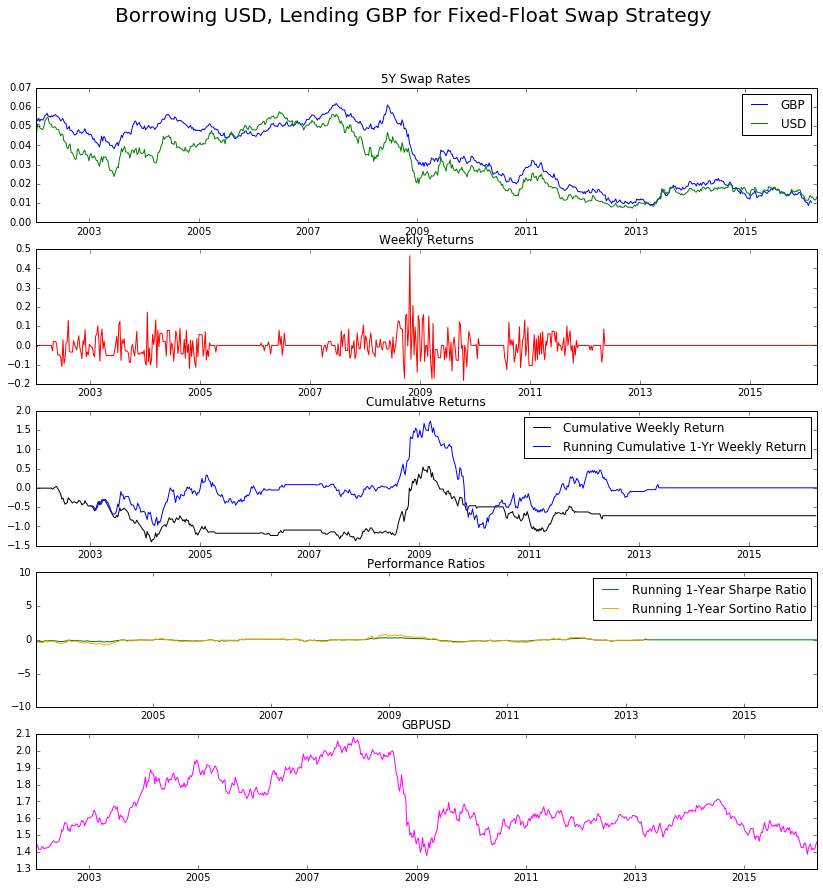

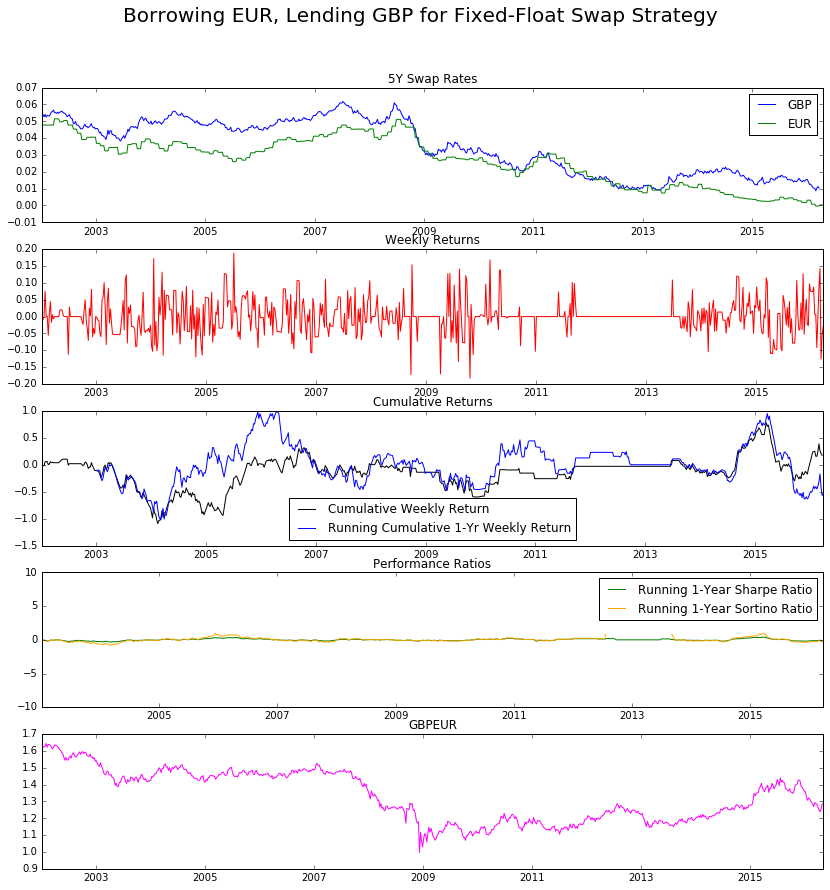

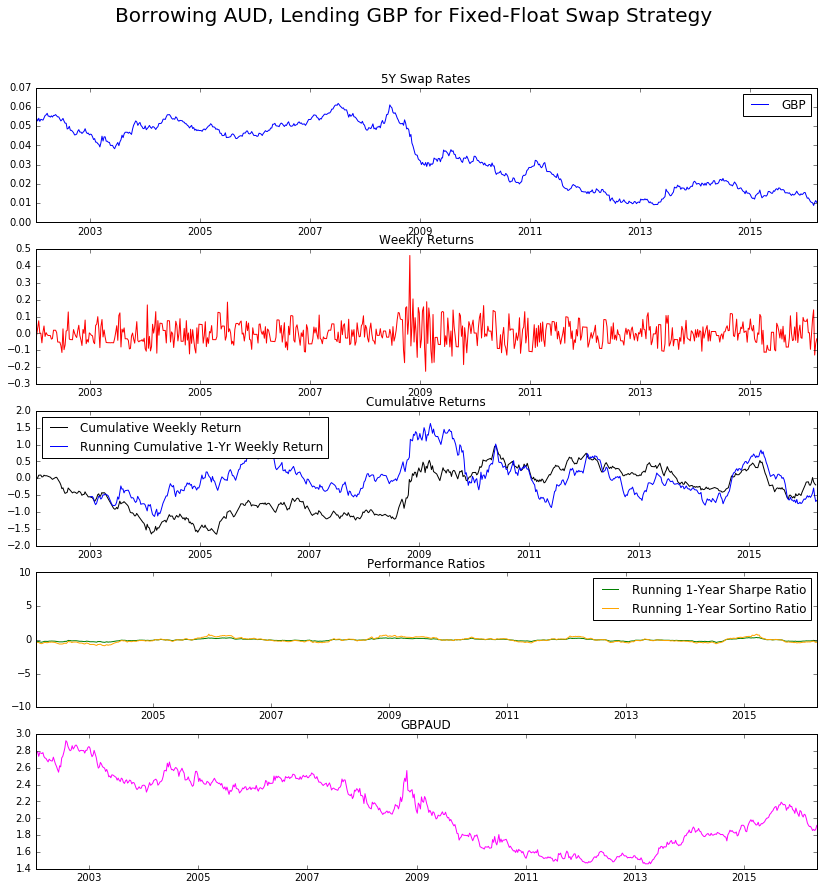

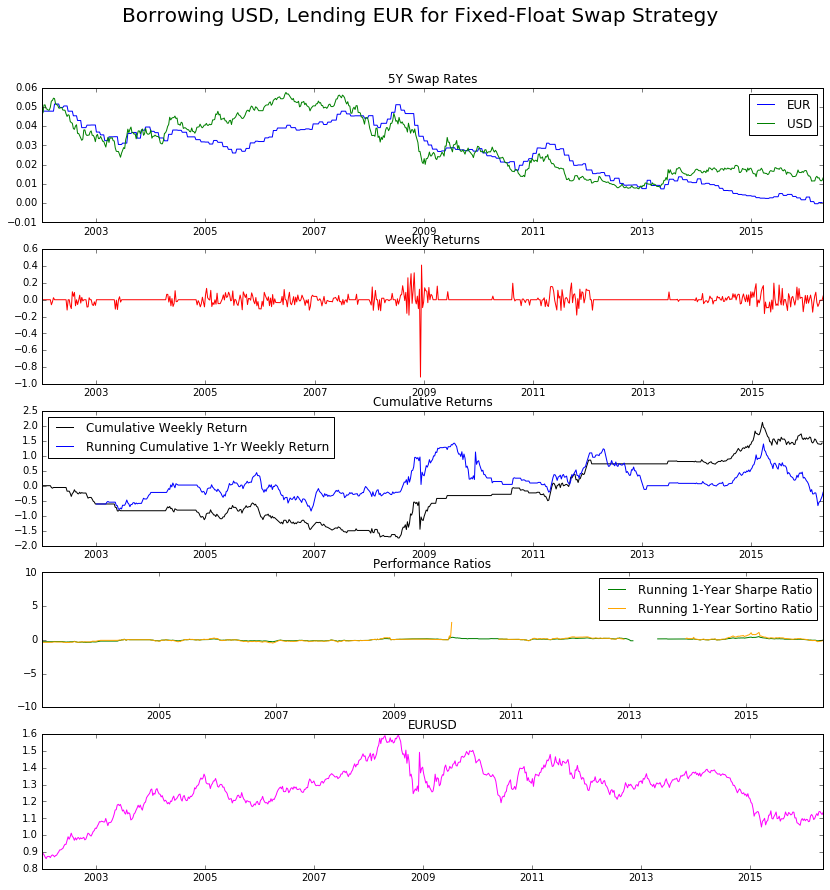

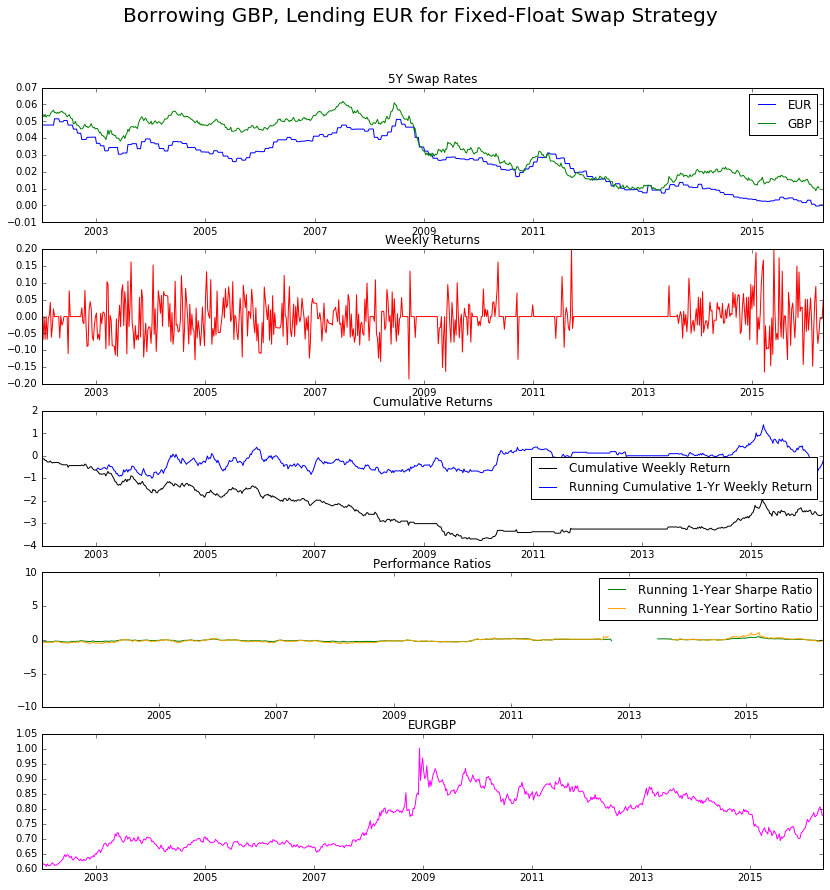

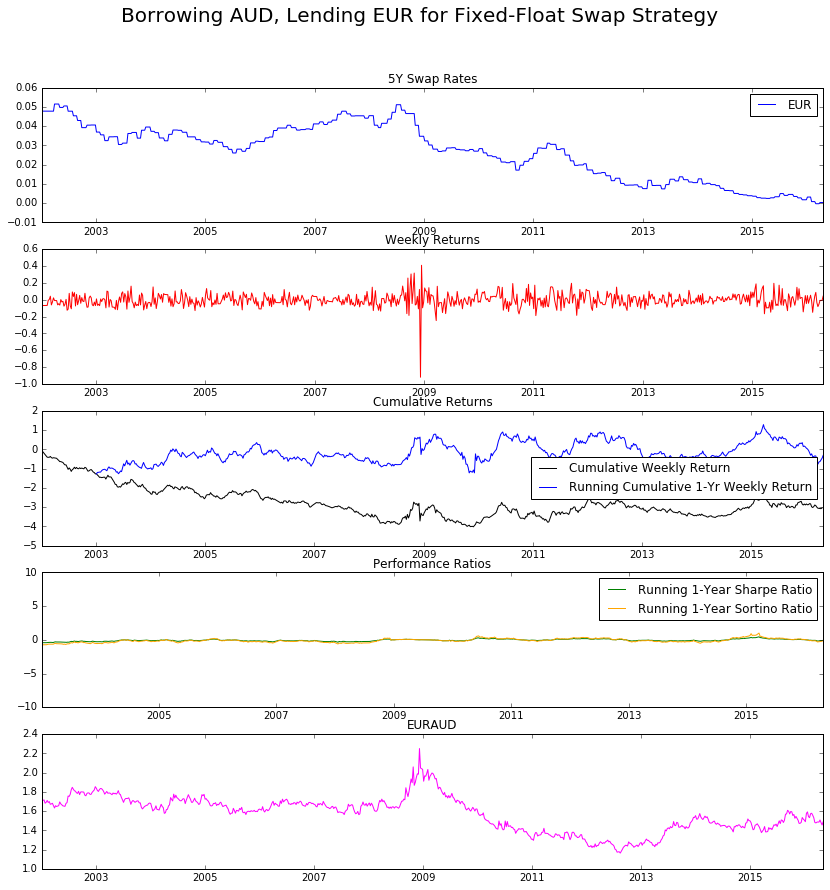

In [20]:
#####################
# fixed-float swaps #
#####################

FF = pd.DataFrame(columns=['Fixed','Floating']) # currency pairs to analyze
FF.loc[0] = ['USD','GBP']
FF.loc[1] = ['USD','EUR']
FF.loc[2] = ['USD','AUD']
FF.loc[3] = ['GBP','USD']
FF.loc[4] = ['GBP','EUR']
FF.loc[5] = ['GBP','AUD']
FF.loc[6] = ['EUR','USD']
FF.loc[7] = ['EUR','GBP']
FF.loc[8] = ['EUR','AUD']

for pair in range(0,len(FF)):
    
    # exception for currencies within 50bps of each other
  if FF.Floating[pair] == 'AUD':
    Signal = 1 + LIBOR.ix[:,0]*0 # just run the strategy for fixed AUD anyway
  else:  
    Signal = 1-1*(np.abs(swap[FF.Fixed[pair]]['5'] - swap[FF.Floating[pair]]['5']) <= 0.005) 
    
    # cashflows from fixed side  
  if FF.Fixed[pair] == 'USD':
    Fixed_CF = swap_zcb[FF.Fixed[pair]].MTM # no need to adjust by exchange rate (because USD)
  else:
    Fixed_CF = swap_zcb[FF.Fixed[pair]].MTM/USDFX['USD'+FF.Fixed[pair]] # adjust by exchange rate
  
  Floating_CF = LIBOR[FF.Floating[pair]+'Accrued']  # floating cashflows
  df = pd.concat((Fixed_CF,Floating_CF,Signal),axis=1) # join cashflows and signal into one dataframe
  df.columns = ['Fixed_CF','Floating_CF','Signal']
  df['Net_CF'] = df.Signal*(df.Fixed_CF - df.Floating_CF) # find net cashflows
  df['Ret'] = df.Net_CF/K # weekly return is net cashflows divided by capital in play
  df['NegRet'] = df.Ret # needed for sortino ratio
  df.NegRet[df.Ret>=0] = np.nan # remove unncessary values for Sortino ratio
  df['CumRet'] = np.cumsum(df.Net_CF)/K 
  df['1YrRollingCumRet'] = pd.rolling_sum(df.Net_CF, 52).shift(1)/K # 1 yearrolling cumulative returns
  df['1YrRollingSharpe'] = pd.rolling_mean(df.Ret,52).shift(1)/pd.rolling_std(df.Ret,52).shift(1)
  df['1YrRollingSortino'] = pd.rolling_mean(df.Ret,52).shift(1)/pd.rolling_std(df.NegRet,52,min_periods=1).shift(1)
    #plots
  plt.figure(figsize=(14,14))
  plt.suptitle('Borrowing {}, Lending {} for Fixed-Float Swap Strategy'.format(FF.Floating[pair],FF.Fixed[pair]),fontsize=20)
  plt.subplot(511)
  plt.title('5Y Swap Rates')
  plt.plot(swap[FF.Fixed[pair]]['5'],label= FF.Fixed[pair])
  if FF.Floating[pair] != 'AUD':
    plt.plot(swap[FF.Floating[pair]]['5'],label= FF.Floating[pair])
  plt.legend([FF.Fixed[pair],FF.Floating[pair]],loc='best')
  plt.subplot(512)
  plt.title('Weekly Returns')
  plt.plot(df.Ret,color='red')
  plt.xlabel('')
  plt.subplot(513)
  plt.title('Cumulative Returns')
  plt.plot(df.CumRet,color='black')
  plt.plot(df['1YrRollingCumRet'],color='blue')
  plt.xlabel('')
  plt.legend(['Cumulative Weekly Return','Running Cumulative 1-Yr Weekly Return'],loc='best')
  plt.subplot(514)
  plt.title('Performance Ratios')
  plt.ylim(-10,10)
  plt.plot(df['1YrRollingSharpe'],color='green')
  plt.plot(df['1YrRollingSortino'],color='orange')
  plt.xlabel('')
  plt.legend(['Running 1-Year Sharpe Ratio','Running 1-Year Sortino Ratio'],loc='best')
  plt.subplot(515)
  plt.title('{}{}'.format(FF.Fixed[pair],FF.Floating[pair]))
  if FF.Fixed[pair] == 'USD':
    plt.plot(USDFX[str('USD'+FF.Floating[pair])],color='magenta')
  elif FF.Floating[pair] == 'USD':
    plt.plot(1/USDFX[str('USD'+FF.Fixed[pair])],color='magenta')
  else:
    plt.plot(USDFX[str('USD'+FF.Floating[pair])]/USDFX[str('USD'+FF.Fixed[pair])],color='magenta')
  plt.show()

### General comments for all results:
* **We are told to not trade when the 5Y swaps are 50bps within reach of each other, but this constraint is prone to losing money since a direction is not specified.  For example, If the GBP 5Y swap is 200bps greater than the USD 5Y swap and we are borrowing GBP and lending USD, we still trade and have a much higher probability of losing money.  Otherwise the strategy would be much more profitable**
* **There are sometimes gaps in the performance ratios, specifically the Sortino ratio, since the strategy may be profitable each week for an entire year**
* **Sometimes cumulative returns are smooth.  This is the case when we are lending at USD, because there is not foreign exchange conversion on the fixed side.  On the float side, smoother results are produced as the cash flow is the accrued amount, and LIBOR does not fluctuate much. ** 
* **From the point above, the strategy does better when lending in USD, which suggests the significant decrease in foreign exchange risk improves the strategy.**
* **This strategy appears to be affected much more by foreign exchange movements versus interest rate movements.  Profitability of the strategies often switches after the 2008 Global Financial Crisis, which caused a regime shift in foreign exchange rates.**
* **From the point above, Sharpe and Sortino ratios are very flat for pairs where the fixed side is not in USD.  Whereas these ratios can fluctuate much more when foreign exchange risk is introduced.**
* **From 2010, the EU crisis began to emerge, which seems to be when LIBOR rates of the analyzed currencies started to converge.**
* **The above point moves hand in hand with the tightening of financial regulations, which have also steadied interest rates globally**
* **The strategy overall with the given constraints seems to be ineffective.  This could also have to do with the fact that the currencies analyzed are all from developed countries.  This in turn means that interest rates are generally low.  If, for example, we could borrow at GBP and lend at BRA, then we may have a much more profitable (yet riskier) strategy to analyze.**

**And here is the same approach as above, except for the basis swap strategy, whereby only the LIBOR dataframe created is used for borrowing and lending cashflows:**

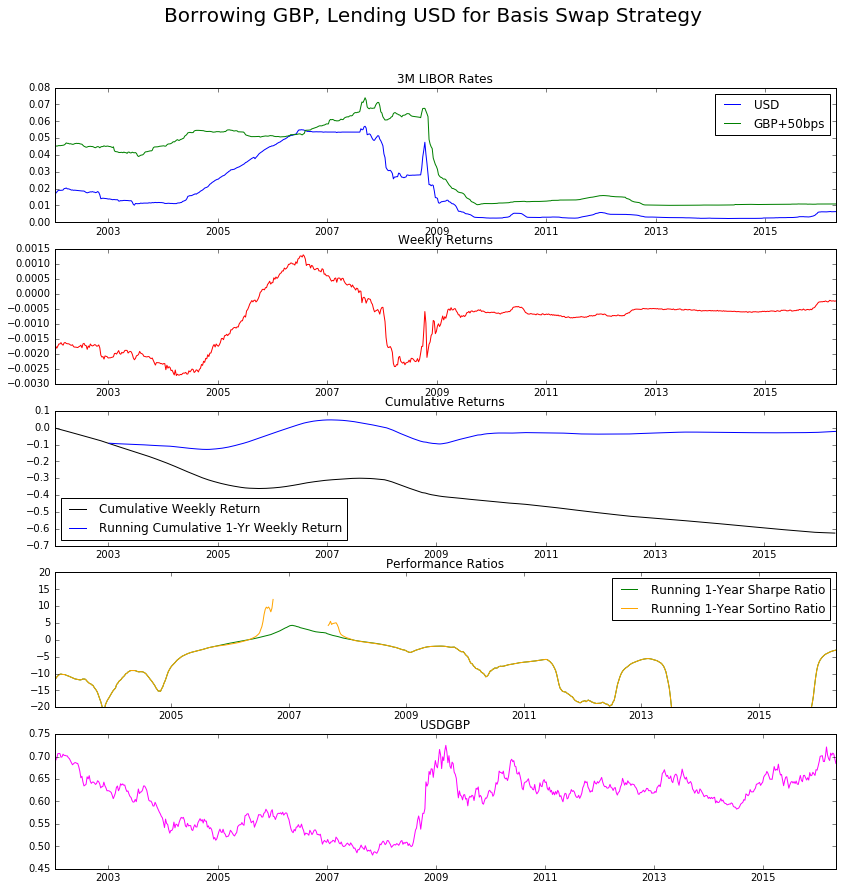

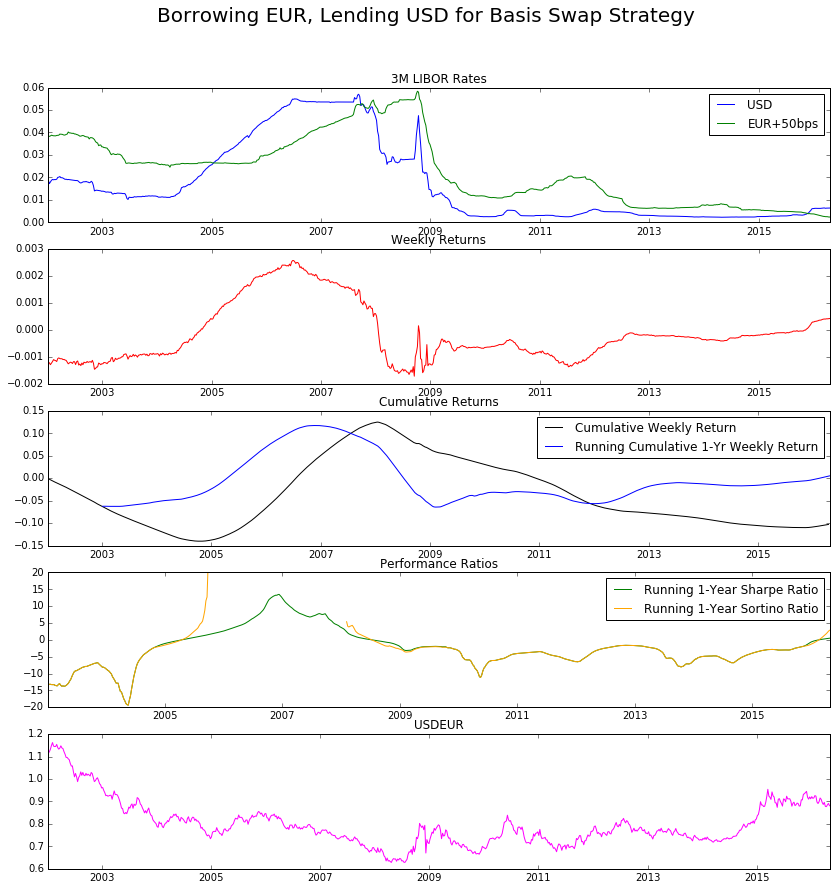

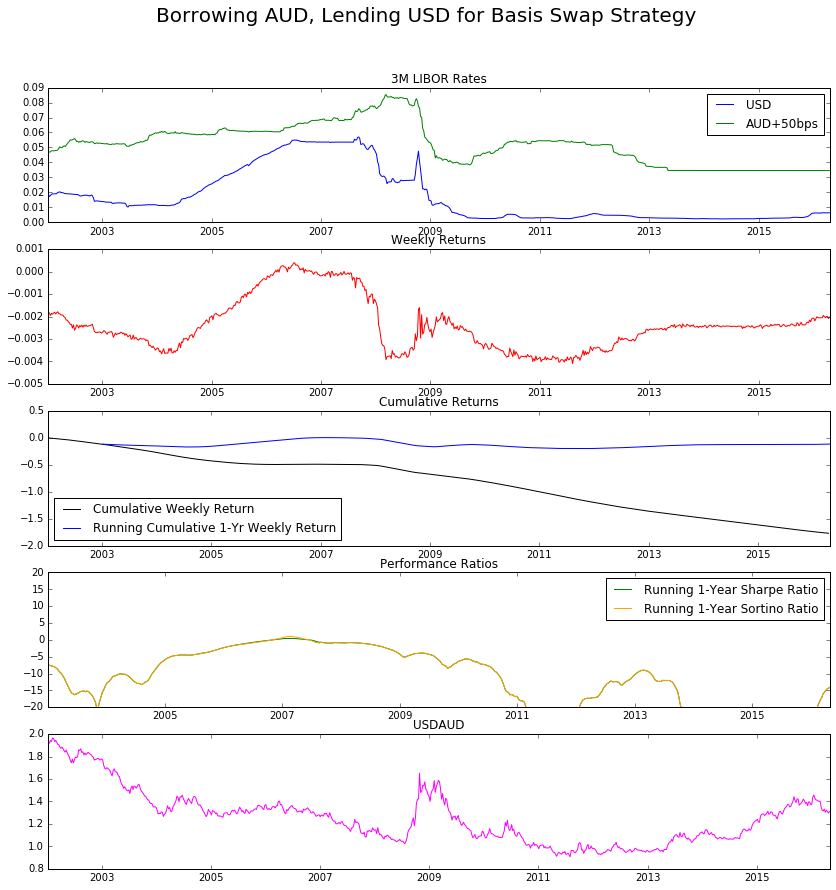

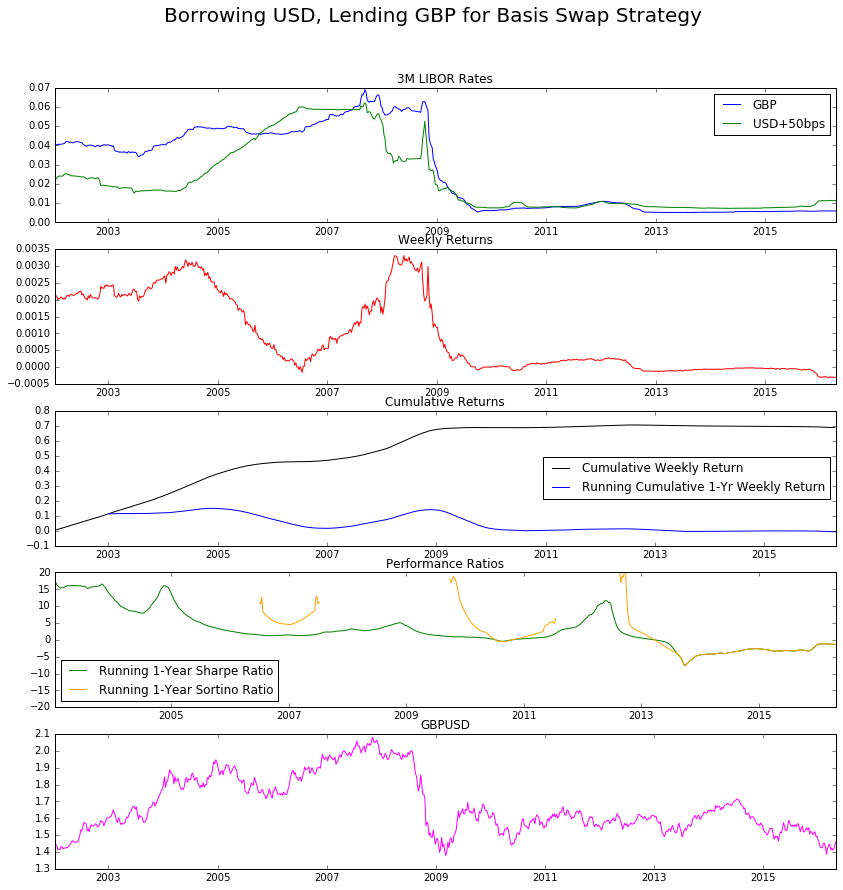

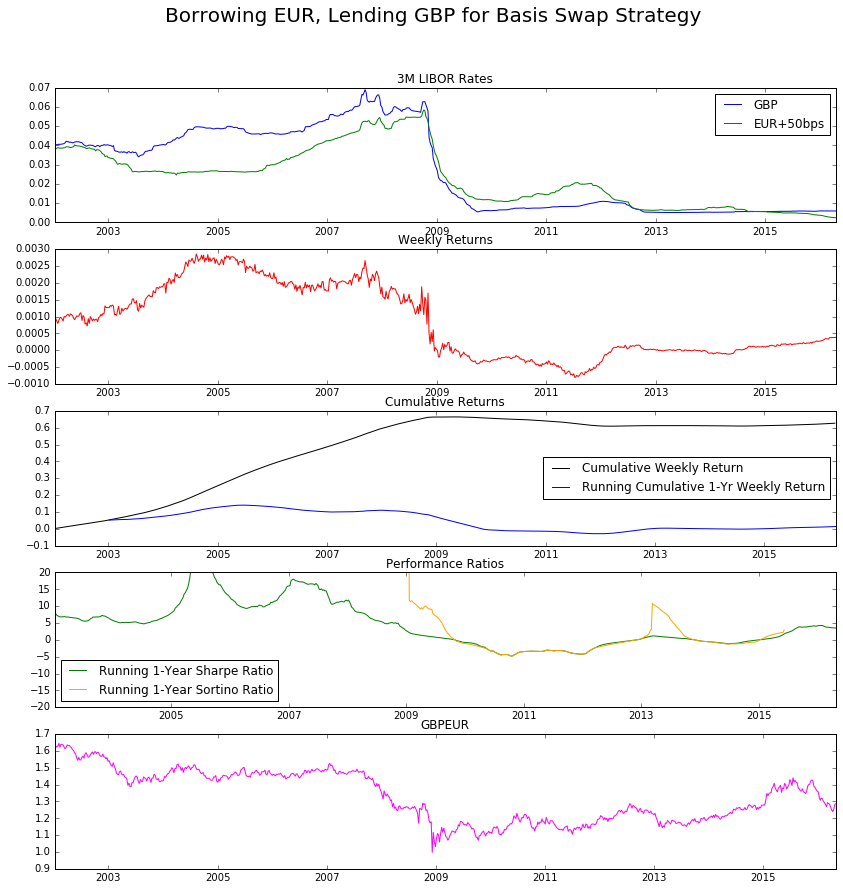

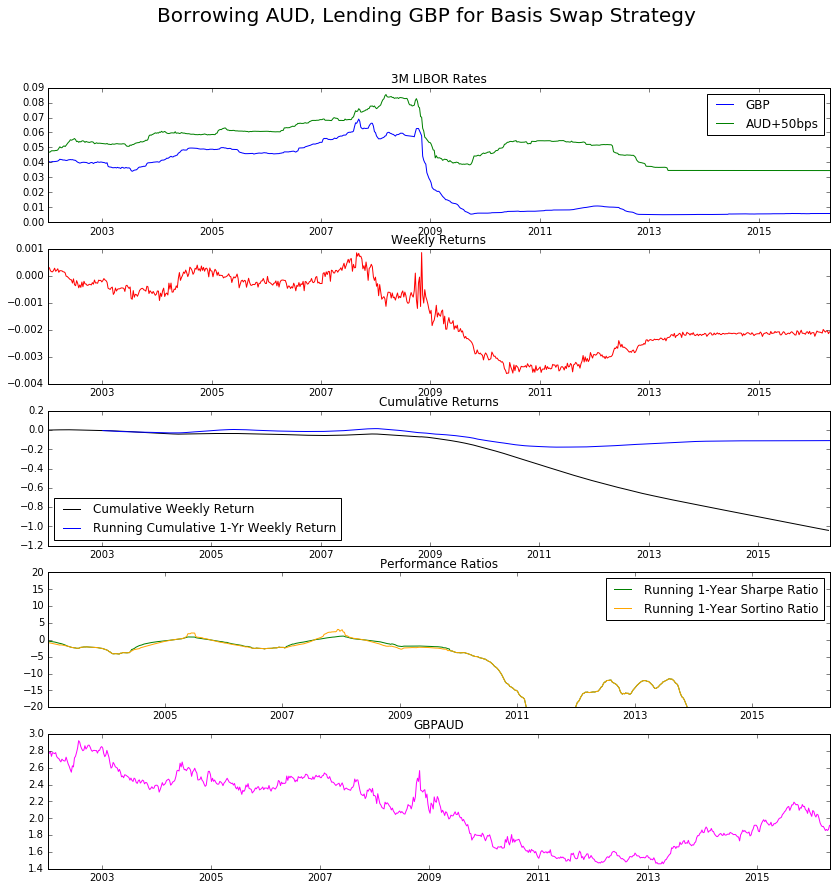

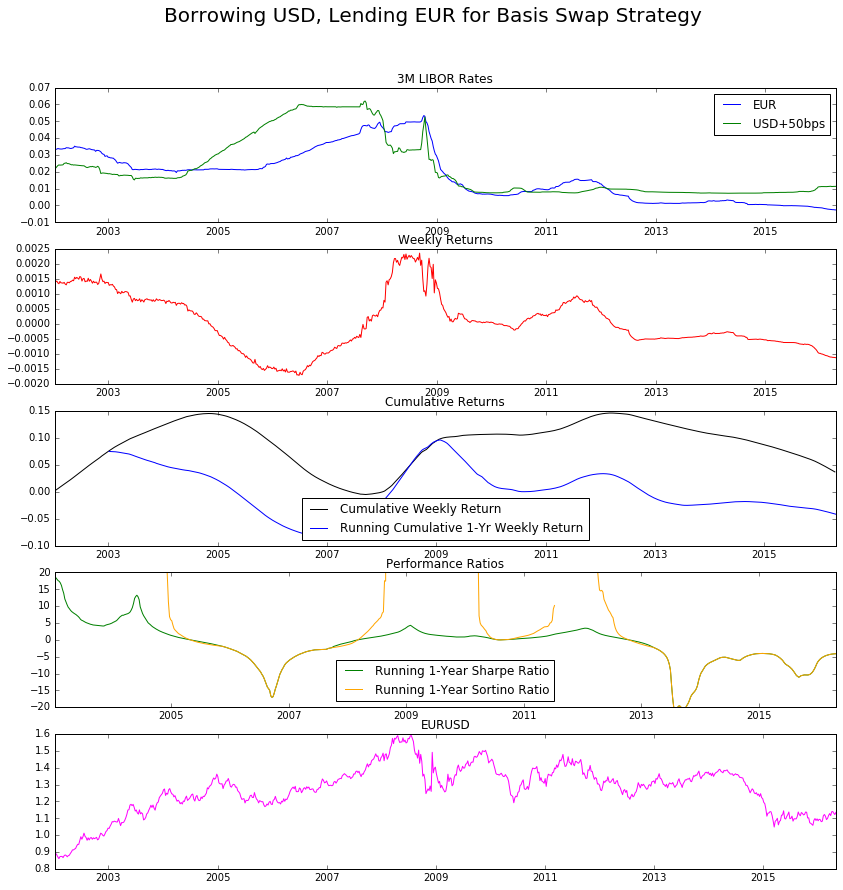

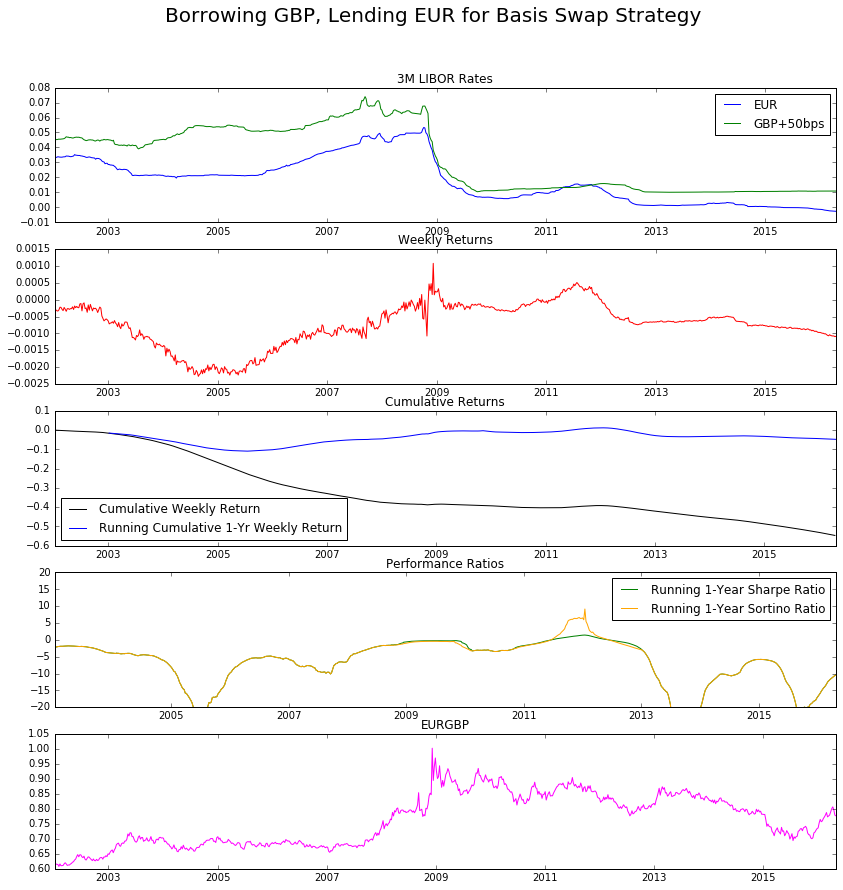

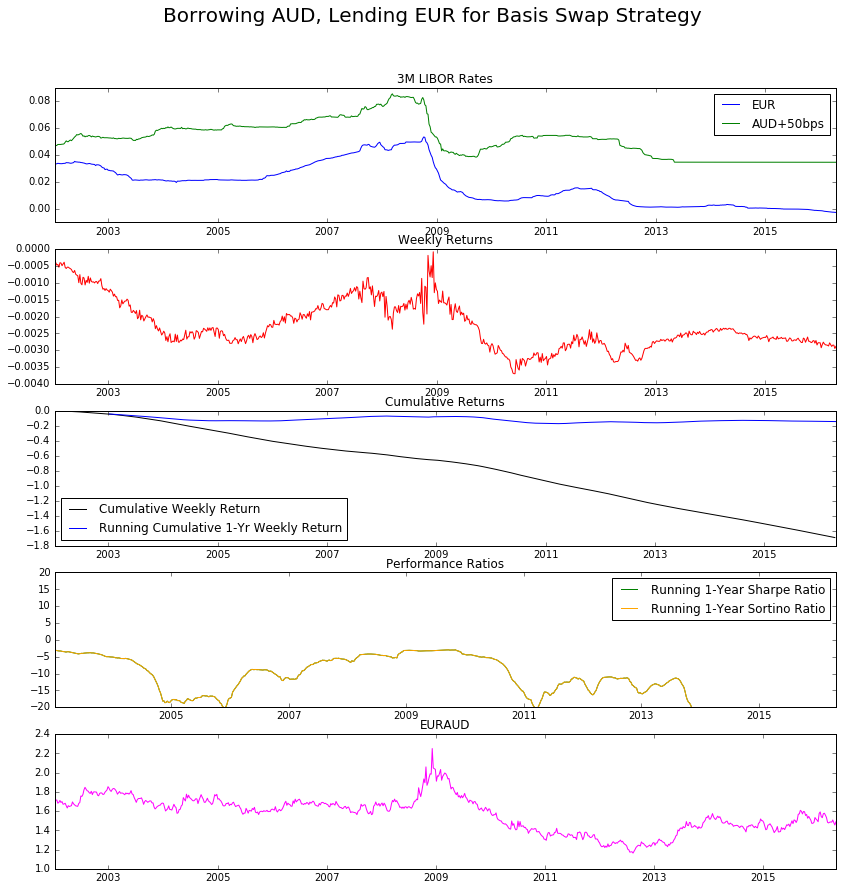

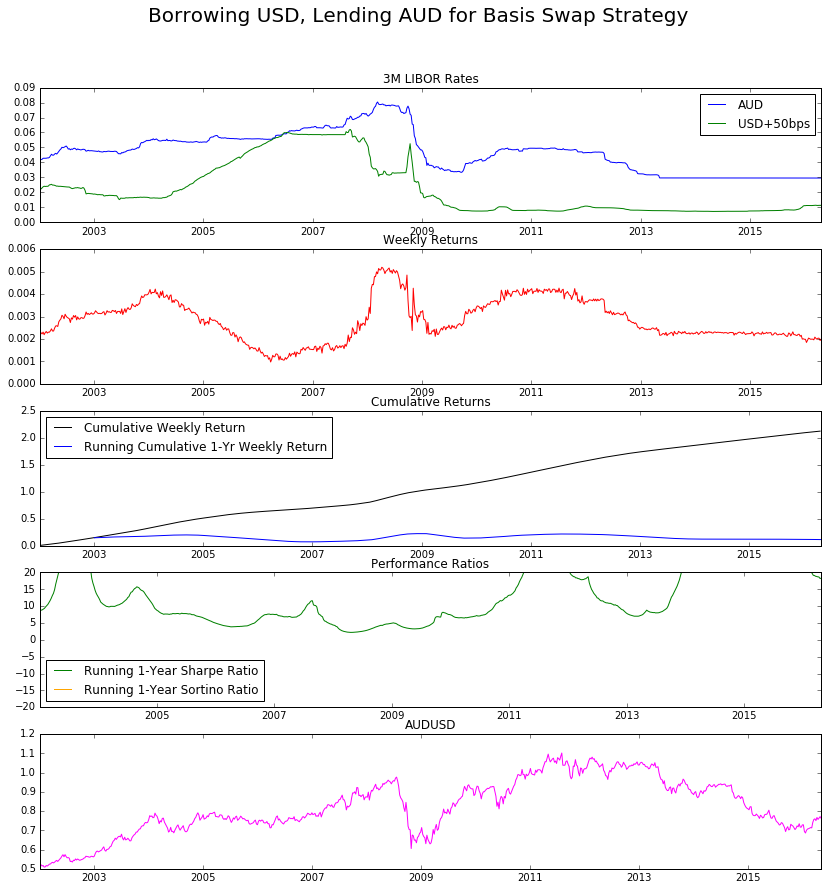

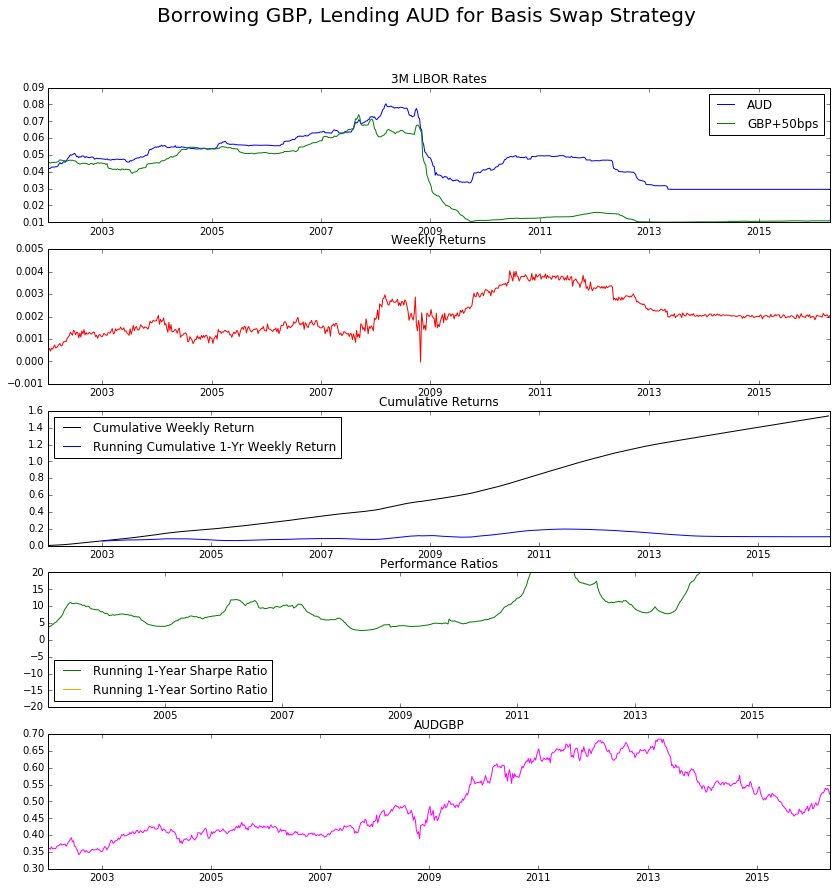

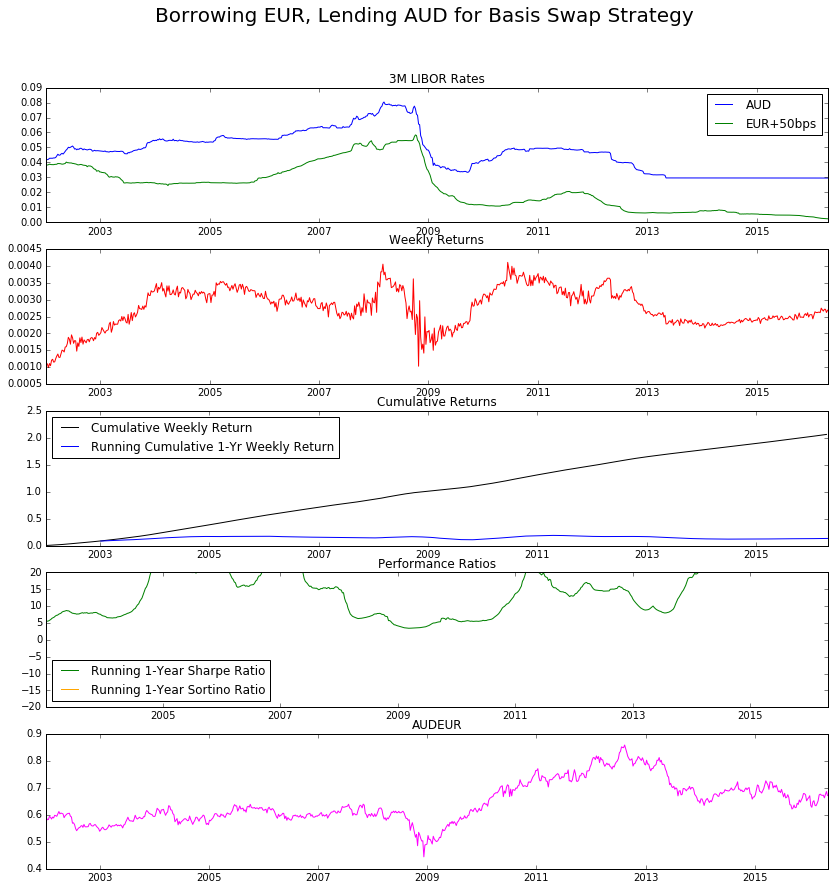

In [22]:
###############
# basis swaps #
###############

B = pd.DataFrame(columns=['Fund','Borrow'])
B.loc[0] = ['USD','GBP']
B.loc[1] = ['USD','EUR']
B.loc[2] = ['USD','AUD']
B.loc[3] = ['GBP','USD']
B.loc[4] = ['GBP','EUR']
B.loc[5] = ['GBP','AUD']
B.loc[6] = ['EUR','USD']
B.loc[7] = ['EUR','GBP']
B.loc[8] = ['EUR','AUD']
B.loc[9] = ['AUD','USD']
B.loc[10] = ['AUD','GBP']
B.loc[11] = ['AUD','EUR']

for pair in range(0,len(B)):
  Fund_CF = LIBOR[B.Fund[pair]+'Accrued_lend']
  Borrow_CF = LIBOR[B.Borrow[pair]+'Accrued']

  df = pd.concat((Fund_CF,Borrow_CF),axis=1)
  df.columns = ['Fund_CF','Borrow_CF']
  df['Net_CF'] = df.Fund_CF - df.Borrow_CF
  df['Ret'] = df.Net_CF/K
  df['NegRet'] = df.Ret # needed for sortino ratio
  df.NegRet[df.Ret>=0] = np.nan
  df['CumRet'] = np.cumsum(df.Net_CF)/K 
  df['1YrRollingCumRet'] = pd.rolling_sum(df.Net_CF, 52).shift(1)/K
  df['1YrRollingSharpe'] = pd.rolling_mean(df.Ret,52).shift(1)/pd.rolling_std(df.Ret,52).shift(1)
  df['1YrRollingSortino'] = pd.rolling_mean(df.Ret,52).shift(1)/pd.rolling_std(df.NegRet,52,min_periods=1).shift(1)
  plt.figure(figsize=(14,14))
  plt.suptitle('Borrowing {}, Lending {} for Basis Swap Strategy'.format(B.Borrow[pair],B.Fund[pair]),fontsize=20)
  plt.subplot(511)
  plt.title('3M LIBOR Rates')
  plt.plot(LIBOR[B.Fund[pair]+'3M'],label= B.Fund[pair])
  plt.plot(LIBOR[B.Borrow[pair]+'3M']+0.005,label= B.Borrow[pair]+'+50bps')
  plt.legend([B.Fund[pair],B.Borrow[pair]+'+50bps'],loc='best')
  plt.subplot(512)
  plt.title('Weekly Returns')
  plt.plot(df.Ret,color='red')
  plt.xlabel('')
  plt.subplot(513)
  plt.title('Cumulative Returns')
  plt.plot(df.CumRet,color='black')
  plt.plot(df['1YrRollingCumRet'],color='blue')
  plt.xlabel('')
  plt.legend(['Cumulative Weekly Return','Running Cumulative 1-Yr Weekly Return'],loc='best')
  plt.subplot(514)
  plt.title('Performance Ratios')
  plt.ylim(-20,20)
  plt.plot(df['1YrRollingSharpe'],color='green')
  plt.plot(df['1YrRollingSortino'],color='orange')
  plt.xlabel('')
  plt.legend(['Running 1-Year Sharpe Ratio','Running 1-Year Sortino Ratio'],loc='best')
  plt.subplot(515)
  plt.title('{}{}'.format(B.Fund[pair],B.Borrow[pair]))
  if B.Fund[pair] == 'USD':
    plt.plot(USDFX[str('USD'+B.Borrow[pair])],color='magenta')
  elif B.Borrow[pair] == 'USD':
    plt.plot(1/USDFX[str('USD'+B.Fund[pair])],color='magenta')
  else:
    plt.plot(USDFX[str('USD'+B.Borrow[pair])]/USDFX[str('USD'+B.Fund[pair])],color='magenta')
  plt.show()

### General comments for all results:
* **There are sometimes gaps in the performance ratios, specifically the Sortino ratio, since the strategy may be profitable each week for an entire year**
* **This strategy appears to be affected much more by foreign exchange movements versus interest rate movements.  Profitability of the strategies often switches after the 2008 Global Financial Crisis, which caused a regime shift in foreign exchange rates.**
* **From 2010, the EU crisis began to emerge, which seems to be when LIBOR rates of the analyzed currencies started to converge.**
* **The above point moves hand in hand with the tightening of financial regulations, which have also steadied interest rates globally**

### Comments for each pair [Lending, Borrowing]:
** I have decided to look at one side of this swap strategy, since the opposite side generally yields opposite results.  E.g. I will not comment on both [USD, EUR] and [EUR, USD].  **

* **USD, GBP**
 * This strategy is mostly unprofitable, because we are borrowing at a more expensive rate up until mid 2006.  After this point, the strategy becomes slightly profitable, but the the regime shift in the exchange rate after the financial crsis makes the strategy unprofitable yet again.  
 * The weekly loss on the strategy plateaus out around 2010 when the exchange rate stabilizes.
* **GBP, EUR**
 * This strategy is quite profitable up until the Financial Crisis, since until then the borrowing rate is well below the lending rate, and the exchange rate is stable.  
 * The strategy then plateaus out around 2010 around the beginning of the EU crisis, when interest rates converged.
* **AUD, GBP**
 * This pair is interesting, since it appears that the strategy should be profitable pre-GFC.  However it isn't due to the constant decline in the GBPAUD interest rate.  
 * However, after interest rates stable out post-Finacial Crisis and EU Crisis (and with increased financial regulation), the spread is interest rates is so large, such that the strategy is still profitable regardless of the exchange rate moving in the same manner
* **EUR, USD**
 * The EUR and USD LIBOR rates have been locked from post-Financial Crisis, which makes the strategy mostly sensitive to foreign exchange movements.  Overall it has not been profitable since the EURUSD exchange rate is depreciating with equal interest rates.  
* **EUR, AUD**
 * The borrowing currency is consistently higher than the lending currency, so naturally this strategy fails to make money.  The opposite strategy would be much better.  
* **AUD, USD**
 * This strategy proves to be profitable pre-Financial Crisis, since the borrowing rate is much lower than the lending rate. Even after the Financial Crisis, the strategy has become even more profitable due to the exchange rate appreciating for AUD.  The steadying interest rates have also made this strategy cosistently profitable, however a depreciation in the AUDUSD interest rate has undermined this some.  